In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using NLsolve
using Plots
using BenchmarkTools
using Distributed
using IntervalArithmetic, IntervalRootFinding

include("/home/julian/Hamburg/LadderDGA/run.jl");

using 8 workers.
      From worker 2:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


      From worker 4:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 6:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 7:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 8:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 3:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`
      From worker 5:	 Activating environment at `~/Hamburg/LadderDGA/Project.toml`


┌ Warning: ArgParse not working with jupyter notebooks
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:48
┌ Warning: Check U and Beta consistency in chi_dir/gamma_dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:49
┌ Info: Reading Inputs...
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/DepsInit.jl:51
┌ Info: Reading Fortran Input, this can take several minutes.
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:95
┌ Info: Done Reading Gamma
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:109
┌ Info: Done Reading chi
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/IO.jl:111
┌ Info: loading from 
│   env.inputVars = vars.jld
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:62
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA /home/julian/Hamburg/LadderDGA/src/helpers.jl:72
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local 

[ Info: Done.


In [2]:
modelParams, simParams, env, impQ_sp, impQ_ch, GImp_pos, Σ_loc_pos, FUpDo  = LadderDGA.setup_LDGA("config.toml", false);
mP = LadderDGA.modelParams;
sP = LadderDGA.simParams;
qMultiplicity = LadderDGA.qMultiplicity;
function subtract_tail(inp, Ekin, mP)
    res = zeros(eltype(inp), size(inp)...)
    iωₙ2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iωₙ2_full[i] = (LadderDGA.iω(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iωₙ2_full[n] != 0
            res[n] = inp[n] - (Ekin/iωₙ2_full[n])
        else
            res[n] = inp[n]
        end
    end
    return res
end

function subtract_tail!(inp, Ekin, mP)
    iωₙ2_full  = zeros(length(inp))
    for i in 1:length(inp)
        iωₙ2_full[i] = (LadderDGA.iω(i - ceil(Int64, length(inp)/2) - 0))^2
    end
    for n in 1:length(inp)
        if iωₙ2_full[n] != 0
            inp[n] -= (Ekin/iωₙ2_full[n])
        end
    end
end

[ Info: Reading Fortran Input, this can take several minutes.
[ Info: Done Reading Gamma
[ Info: Done Reading chi
┌ Info: loading from 
└   env.inputVars = "vars.jld"
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ Main.LadderDGA ~/Hamburg/LadderDGA/src/helpers.jl:72


subtract_tail! (generic function with 1 method)

In [3]:
tc = true
usable_ω = intersect(nlQ_sp.usable_ω, nlQ_ch.usable_ω);
rχsp = real.(nlQ_sp.χ[usable_ω,:]);
rχch = real.(nlQ_ch.χ[usable_ω,:]);
rhs_val = tc ? (mP.n) * (1 - mP.n/2) : real(impQ_sp.χ_loc + impQ_ch.χ_loc)

χ_λ(χ, λ) = map(χi -> 1.0 / ((1.0 / χi) + λ), χ)
nc = [0,1,2,3]
NW = floor(Int64, size(rχch, 1)/2)
ωmin = Int(floor(NW*1/4))
ωmax = NW 
W = LadderDGA.build_weights(ωmin, ωmax, [0,1,2,3])

iνₙ, GImp_pos    = LadderDGA.readGImp(LadderDGA.env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(LadderDGA.env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:5000], ϵₖ, Vₖ, GImp_pos[1:5000], mP)
rem_full = -E_kin_ED*(mP.β*mP.β)/12

function construct_f!(F, λ, rhs)#default rhs χLocsp + χLocch or n/2 (1-n/2)
    χsp_λ = χ_λ(rχ_sp, λ[1])
    χch_λ = χ_λ(rχ_ch, λ[2]) 
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, qMultiplicity, dims=2)[:,1]
    #, [1], tc, mP.β, weights=W)[1]  
    tmp =  (sum(subtract_tail(χupup, E_kin_ED, mP))+rem_full)/mP.β        
    F[1] = real(tmp - rhs)
end


function construct_f(λsp, λch, χsp, χch; mode=:naive, rhs=rhs_val) 
    χsp_λ = LadderDGA.χ_λ(χsp, λsp)
    χch_λ = LadderDGA.χ_λ(χch, λch)
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
    nwh = ceil(Int64, size(χsp,1)/2)
    tmp = 0.0 - sum(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)]) - sum(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])
    #println("penalty = $tmp")
    #println("eval λsp = $λsp, λch = $λch")
    if mode == :naive
        tmp += real(sum(χupup)/mP.β - rhs)
    elseif mode == :sub
        tmp +=  real((sum(subtract_tail(χupup, E_kin_ED, mP)) + rem_full)/mP.β - rhs)
    elseif mode == :fit
        tmp +=  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1] - rhs)        
    else
        tmp +=  real(LadderDGA.sum_freq(subtract_tail(χupup, E_kin_ED, mP), [1], true, mP.β, correction=rem_full, weights=W)[1]- rhs)
    end 
    return tmp
end

function construct_df(λsp, λch, χsp, χch; mode=:naive, rhs=rhs_val) 
    χsp_λ = LadderDGA.dχ_λ(χsp, λsp)
    χch_λ = LadderDGA.dχ_λ(χch, λch)
    χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
    tmp = 0.0
    if mode == :naive
        tmp += real(sum(χupup)/mP.β)
    elseif mode == :sub
        tmp +=  real((sum(subtract_tail(χupup, E_kin_ED, mP)) + rem_full)/mP.β)
    elseif mode == :fit
        tmp +=  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1])        
    else
        tmp +=  real(LadderDGA.sum_freq(subtract_tail(χupup, E_kin_ED, mP), [1], true, mP.β, correction=rem_full, weights=W)[1])
    end 
    return tmp
end

construct_df (generic function with 1 method)

# Condition 1

In [4]:
testf(λsp,λch, m) = construct_f(λsp,λch, rχsp, rχch, mode=m, rhs=rhs_val)
testdf(λsp,λch, m) = construct_df(λsp, λch, rχsp, rχch, mode=m, rhs=rhs_val);

## compute λsp(λch) (NLsolve)

In [12]:
tc = sP.tail_corrected
nh = ceil(Int64, size(rχsp,1)/2)
χsp_min    = -minimum(1 ./ rχsp[nh,:])
χch_min    = -minimum(1 ./ rχch[nh,:])
extra_ch = 0.1
λch_range = (χch_min-extra_ch):0.01:(χch_min+1.0)
spOfch_max_nl = zeros(2,size(λch_range)...)
for (mi,m) in enumerate([:naive, :fit])
    println("\rmode: ", m)
    rhs_val = tc ? (mP.n) * (1 - mP.n/2) : real(impQ_sp.χ_loc + impQ_ch.χ_loc)
    for (λi,λchi) in enumerate(λch_range)
        testf!(F,λ) = F[1]=testf(λ[1],λchi, m)
        testdf!(F,λ) = F[1]=testdf(λ[1],λchi, m)
        spOfch_max_nl[mi,λi] = try
            nlsolve(testf!, testdf!, [0.1]).zero[1]
        catch e
            println("caught exception")
            spOfch_max_nl[mi,λi-1]
        end
        print("\r$λi of $(length(λch_range))")
    end
end

mode: naive
10 of 111caught exception
mode: fit1
10 of 111caught exception
111 of 111

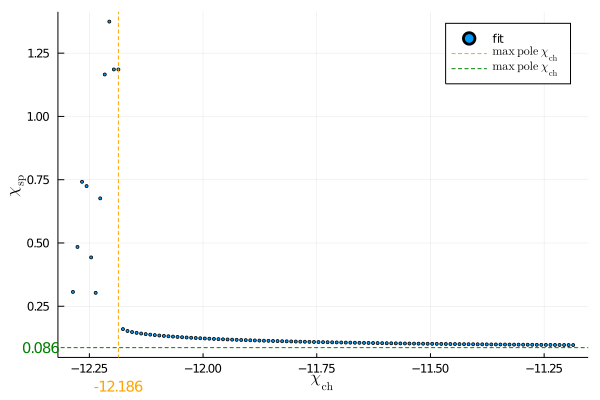

In [73]:
nh = ceil(Int64, size(rχsp,1)/2)
χsp_min    = -minimum(1 ./ rχsp[nh,:])
χch_min    = -minimum(1 ./ rχch[nh,:])
#plot(λch_range,spOfch_max_nl[1,:], label="naive", seriestype=:scatter, markersize=1.8)
#xticks = round.(union(λch_range[1]:((λch_range[end]-λch_range[1])/8):λch_range[end],[χch_min]), digits=2)
plot(λch_range,spOfch_max_nl[2,:], label="fit", xlabel=L"\chi_\mathrm{ch}", ylabel=L"\chi_\mathrm{sp}", seriestype=:scatter, markersize=1.8)
plot!([χch_min], seriestype = :vline, linestyle=:dash, label=L"\mathrm{max\;pole\;}\chi_\mathrm{ch}", color=:orange)
annotate!([χch_min], -0.1, text("$(round(χch_min,digits=3))", 10, :bottom, color=:orange))
plot!([χsp_min], seriestype = :hline, linestyle=:dash, label=L"\mathrm{max\;pole\;}\chi_\mathrm{ch}", color=:green)
annotate!(χch_min - extra_ch - 0.11, [χsp_min], text("$(round(χsp_min,digits=3))", 10, :left, color=:green))

## compute λsp(λch) (Roots) - Deprecated

In [7]:
Xsp = @interval(0.07,0.1)
Xch = @interval(-2,2)
λch_range_c1 = -3.0:0.1:1.0
λch_range2_c1 = -15:1.0:15
spOfch_max_int_c1 = zeros(4,size(λch_range_c1)...)
spOfch_max_int_c1 = zeros(4,size(λch_range_c1)...)
spOfch2_max_int_c1 = zeros(4,size(λch_range2_c1)...)
spOfch3_max_int_c1 = zeros(4,size(λch_range2_c1)...);

In [78]:
for (mi,m) in enumerate([:naive, :fit])
    println("\rmode: ", m)
    rhs_val = (m == :fit || m == :both) ? (mP.n) * (1 - mP.n/2) : real(impQ_sp.χ_loc + impQ_ch.χ_loc)
    for (λi,λchi) in enumerate(λch_range_c1)
        ff(x) = testf(x,λchi,m)
        fdf(x) = testdf(x,λchi,m)
        print("\r", λi, " of ", length(λch_range_c1))
        res_internal = roots(ff, fdf, Xsp, Newton, 1e-6)
        max_int = maximum(interval.(res_internal))
        spOfch_max_int_c1[mi,λi] = mid(max_int)
    end
end
#for (mi,m) in enumerate([:naive, :sub, :fit, :both])
#    println("\rmode: ", m)
#    for (λi,λchi) in enumerate(λch_range2_c1)
#        testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, mode=m, rhs=rhs_val)
#        res_internal = roots(testf, testdf, Xsp, Newton, 1e-5)
#        max_int = maximum(interval.(res_internal))
#        spOfch2_max_int_c1[mi,λi] = mid(max_int)
#        print("\r", rpad(λi,length(string(length(λch_range2_c1)))), " of ", length(λch_range2_c1))
#    end
#end

#for (λi,λchi) in enumerate(λch_range2_c1)
#    testf(λsp) = construct_f(λsp, λchi, rχsp, rχch, qMultiplicity, rhs=rhs)
#    res_internal = roots(testf, Xsp, Newton, 1e-5)
#    max_int = maximum(interval.(res_internal))
#    spOfch3_max_int_c1[λi] = mid(max_int)
#    print("\r", λi, " of ", length(λch_range2_c1))
#end

mode: naive
mode: 41fit
41 of 41

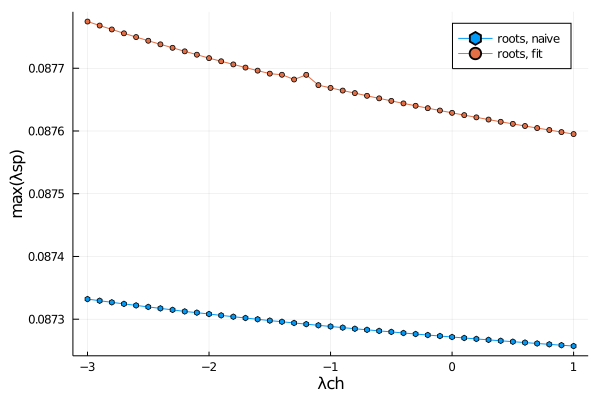

In [15]:
plot(λch_range_c1[1:end], spOfch_max_int_c1[1,1:end], label="roots, naive", xlabel="λch", ylabel="max(λsp)", xticks = λch_range_c1[1:10:end], markershape=:hexagon, markersize=2.8)
plot!(λch_range_c1[1:end], spOfch_max_int_c1[2,1:end], label="roots, fit", xlabel="λch", ylabel="max(λsp)", xticks = λch_range_c1[1:10:end], markershape=:circle, markersize=2.8)
#plot!(λch_range2_c1[10:end], spOfch2_max_int_c1[3,10:end], label="roots, fit", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=2.8)
#plot!(λch_range2_c1[10:end], spOfch2_max_int_c1[4,10:end], label="roots, both", xlabel="λch", ylabel="max(λsp)", xticks = λch_range2_c1[1:10:end],seriestype = :scatter, markersize=2.8)
#savefig("roots_tc_EoMtc.pdf")
#plot!(λch_range, spOfch_max_nl, label="NLsolve", seriestype = :scatter, markersize=0.8)

In [22]:
#using JLD
#save("cond_1_data_b25u1_large_2.jld", "λch_range_c1", λch_range_c1, "spOfch_max_int_c1", spOfch_max_int_c1, "λch_range2_c1", λch_range2_c1, "spOfch2_max_int_c1", spOfch2_max_int_c1)

# Condition 2

In [76]:
function cond_Epot_overview3(λsp, λch, nlQ_sp, nlQ_ch)
    Σ_ladder2, lhs, E_pot = LadderDGA.calc_E_pot_cond(λsp, λch, nlQ_sp, nlQ_ch, bubble, 
                         LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                         LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                         LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                         mP, sP, sP.tail_corrected);
    return lhs, E_pot
end

cond_Epot_overview3 (generic function with 1 method)

In [78]:
λch_range_c2_coarse = -12.2:0.01:-12.0
λsp_range_c2_coarse = 0.18:0.01:0.32
rhs_overview_coarse = Array{Float64,2}(undef, length(λch_range_c2_coarse),length(λsp_range_c2_coarse));
lhs_overview_coarse = Array{Float64,2}(undef, length(λch_range_c2_coarse),length(λsp_range_c2_coarse));

for i in (1:length(λch_range_c2_coarse))
    λch_i = λch_range_c2_coarse[i]
    for (j,λsp_i) in enumerate(λsp_range_c2_coarse)
        lhs, E_pot = cond_Epot_overview3(λsp_i, λch_i, nlQ_sp, nlQ_ch)
        lhs_overview_coarse[i,j] = lhs
        rhs_overview_coarse[i,j] = E_pot
        print("\r", rpad(i,3), " ", rpad(j,3), " = ", rpad((i-1)*length(λsp_range_c2_coarse) + j,4)," of ", length(λch_range_c2_coarse)*length(λsp_range_c2_coarse))   
    end
end

21  15  = 315  of 315 = 156  of 315

0.15727837650553442


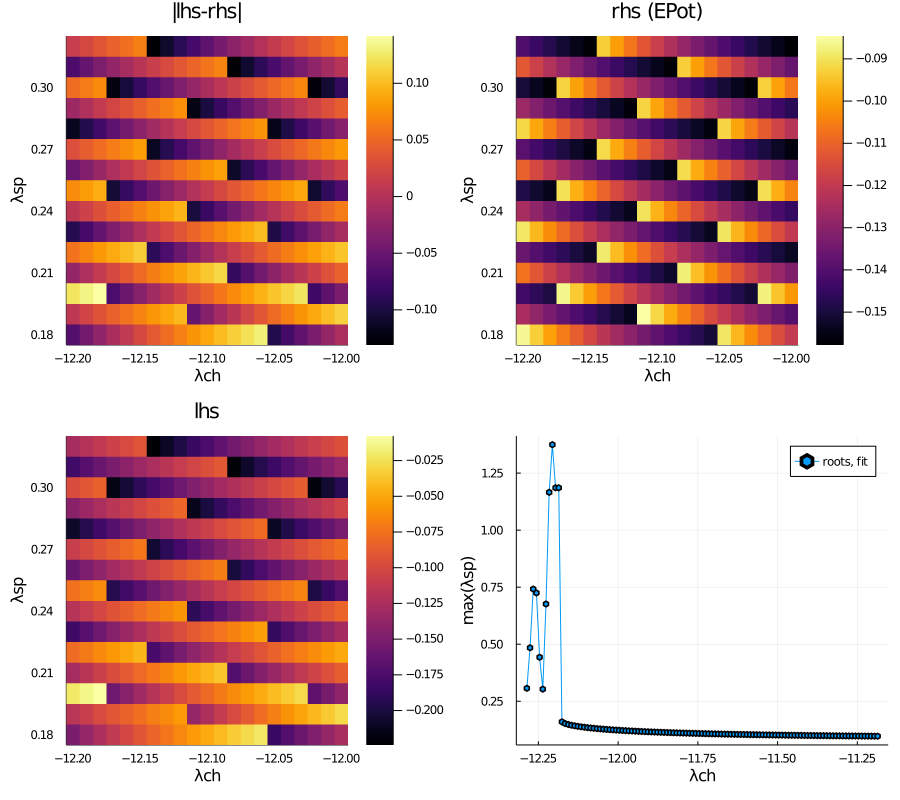

In [90]:
println(minimum(abs.(lhs_overview_coarse .- rhs_overview_coarse)))
plot(heatmap(λch_range_c2_coarse, λsp_range_c2_coarse, (lhs_overview_coarse .- rhs_overview_coarse), xlabel="λch", ylabel="λsp", title="|lhs-rhs|"), 
    heatmap(λch_range_c2_coarse, λsp_range_c2_coarse, rhs_overview_coarse, xlabel="λch", ylabel="λsp", title="rhs (EPot)"), 
    heatmap(λch_range_c2_coarse, λsp_range_c2_coarse, lhs_overview_coarse, xlabel="λch", ylabel="λsp", title="lhs"),
    plot(λch_range[1:end], spOfch_max_nl[2,1:end], label="roots, fit", xlabel="λch", ylabel="max(λsp)", markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))
#writedlm("cond2.csv",  lhs_overview .- rhs_overview, ' ')

In [91]:
λch_range_c2 = -12.2:0.005:-12.0
λsp_range_c2 = 0.18:0.005:0.32
rhs_overview = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));
lhs_overview = Array{Float64,2}(undef, length(λch_range_c2),length(λsp_range_c2));

for i in (1:length(λch_range_c2))
    λch_i = λch_range_c2[i]
    for (j,λsp_i) in enumerate(λsp_range_c2)
        lhs, E_pot = cond_Epot_overview3(λsp_i, λch_i, nlQ_sp, nlQ_ch)
        lhs_overview[i,j] = lhs
        rhs_overview[i,j] = E_pot
        print("\r", rpad(i,3), " ", rpad(j,3), " = ", rpad((i-1)*length(λsp_range_c2) + j,4)," of ", length(λch_range_c2)*length(λsp_range_c2))   
    end
end

41  29  = 1189 of 1189 of 1189

1.6092478806378763e-5


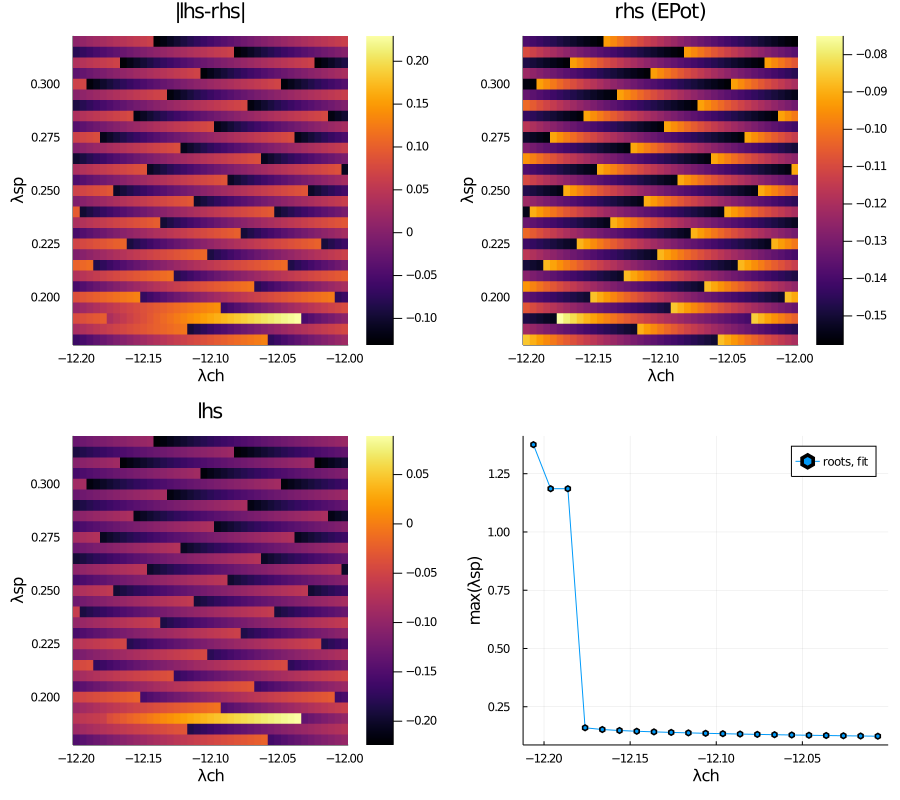

In [109]:
println(minimum(abs.(lhs_overview .- rhs_overview)))
plot(heatmap(λch_range_c2, λsp_range_c2, (lhs_overview .- rhs_overview), xlabel="λch", ylabel="λsp", title="|lhs-rhs|"), 
    heatmap(λch_range_c2, λsp_range_c2, rhs_overview, xlabel="λch", ylabel="λsp", title="rhs (EPot)"), 
    heatmap(λch_range_c2, λsp_range_c2, lhs_overview, xlabel="λch", ylabel="λsp", title="lhs"),
    plot(λch_range[9:end-82], spOfch_max_nl[2,9:end-82], label="roots, fit", xlabel="λch", ylabel="max(λsp)", markershape=:hexagon, markersize=2.8),
    layout=(2,2),size=(900,800))
#writedlm("cond2.csv",  lhs_overview .- rhs_overview, ' ')

In [ ]:
#save("rhs_lhs_tc_EoMtc_b25u1_overview_2.jld", "lhs", lhs_overview, "rhs", rhs_overview, "λch_range_c2", λch_range_c2, "λsp_range_c2", λsp_range_c2)

# Both conditions

In [50]:
mP = LadderDGA.modelParams
sP = LadderDGA.simParams
nc = [0,1,2,3]
NW = floor(Int64, length(usable_ω)/2)
ωmin = 1
ωmax = NW 
coeffs = collect(0:3)
Wω = LadderDGA.build_weights(ωmin, ωmax, coeffs)
println("building  weight matrix from $ωmin to $ωmax with coefficients $(coeffs)")
include("src/ConvergenceAcc.jl")
#Shanks.shanks(E_Pot, csum_inp=true) 

function cond_both_nc!(F, λ)
    Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(λ[1], λ[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1]
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1]) 
    tmp += -penalty
    lhs_c1 = 2 * mP.n/2 * (1 - mP.n/2)
    println("calling for λ=$λ, penalty = $penalty")
    F[1] = tmp - lhs_c1
    F[2] = E_pot_DGA + (lhs_c2)
end

function cond_both_c!(F, λ)
    Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(λ[1], λ[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
    χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ), λ[1])
    χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ), λ[2])
    χupup = LadderDGA.sum_q(χch_λ[usable_ω,:].+ χsp_λ[usable_ω,:], LadderDGA.qMultiplicity, dims=2)[:,1]
    nwh = ceil(Int64, size(χsp_λ,1)/2)
    penalty = sum(abs.(χsp_λ[nwh,(χsp_λ[nwh,:] .< 0)])) + sum(abs.(χch_λ[nwh,(χch_λ[nwh,:] .< 0)])) 
    #penalty2 = length(χch_λ[nwh,((χch_λ[nwh,:] .< 0.01) .& (χch_λ[nwh,:] .>= 0.0))])
    tmp =  real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=W)[1]) 
    tmp += -penalty
    lhs_c1 = 2 * mP.n/2 * (1 - mP.n/2)
    println("calling for λ=$(round.(λ,digits=2)), penalty = $penalty")
    F[1] = tmp - lhs_c1
    F[2] = -E_pot_DGA[1] + (lhs_c2)
end

building  weight matrix from 1 to 6 with coefficients [0, 1, 2, 3]


cond_both_c! (generic function with 1 method)

In [51]:
init = [ 0.1; -0.8]
res_nc = nlsolve(cond_both_nc!, init);
res_c = nlsolve(cond_both_c!, init);

calling for λ=[0.1, -0.8], penalty = 0.0
calling for λ=[0.1000060554544524, -0.8], penalty = 0.0
calling for λ=[0.09999394454554761, -0.8], penalty = 0.0
calling for λ=[0.1, -0.7999939445455476], penalty = 0.0
calling for λ=[0.1, -0.8000060554544525], penalty = 0.0
calling for λ=[0.14416020993908016, -51.017425584125306], penalty = 1.4799294456121093
calling for λ=[0.12208010496954008, -25.90871279206265], penalty = 4.40420712839939
calling for λ=[0.11104005248477004, -13.354356396031324], penalty = 127.67816354296565
calling for λ=[0.10552002624238502, -7.077178198015661], penalty = 0.0
calling for λ=[0.10552002624238502, -7.077178198015661], penalty = 0.0
calling for λ=[0.10552608169683741, -7.077178198015661], penalty = 0.0
calling for λ=[0.10551397078793262, -7.077178198015661], penalty = 0.0
calling for λ=[0.10552002624238502, -7.077135342485431], penalty = 0.0
calling for λ=[0.10552002624238502, -7.07722105354589], penalty = 0.0
calling for λ=[0.13872141963294554, -18.34578381379

calling for λ=[0.12, -33.75], penalty = 2.7225907587396834
calling for λ=[0.11, -17.28], penalty = 13.897934880618976
calling for λ=[0.1, -9.04], penalty = 0.0
calling for λ=[0.1, -9.04], penalty = 0.0
calling for λ=[0.1, -9.04], penalty = 0.0
calling for λ=[0.1, -9.04], penalty = 0.0
calling for λ=[0.1, -9.04], penalty = 0.0
calling for λ=[0.1, -9.04], penalty = 0.0
calling for λ=[0.14, -20.74], penalty = 7.437393172471664
calling for λ=[0.12, -14.89], penalty = 37.73558497605534
calling for λ=[0.11, -11.96], penalty = 0.0
calling for λ=[0.11, -11.96], penalty = 0.0
calling for λ=[0.11, -11.96], penalty = 0.0
calling for λ=[0.11, -11.96], penalty = 0.0
calling for λ=[0.11, -11.96], penalty = 0.0
calling for λ=[0.11, -11.96], penalty = 0.0
calling for λ=[0.16, -12.55], penalty = 47.87915391513788
calling for λ=[0.14, -12.46], penalty = 74.70361003569106
calling for λ=[0.13, -12.21], penalty = 37.031084609032995
calling for λ=[0.12, -12.09], penalty = 0.0
calling for λ=[0.12, -12.09], p

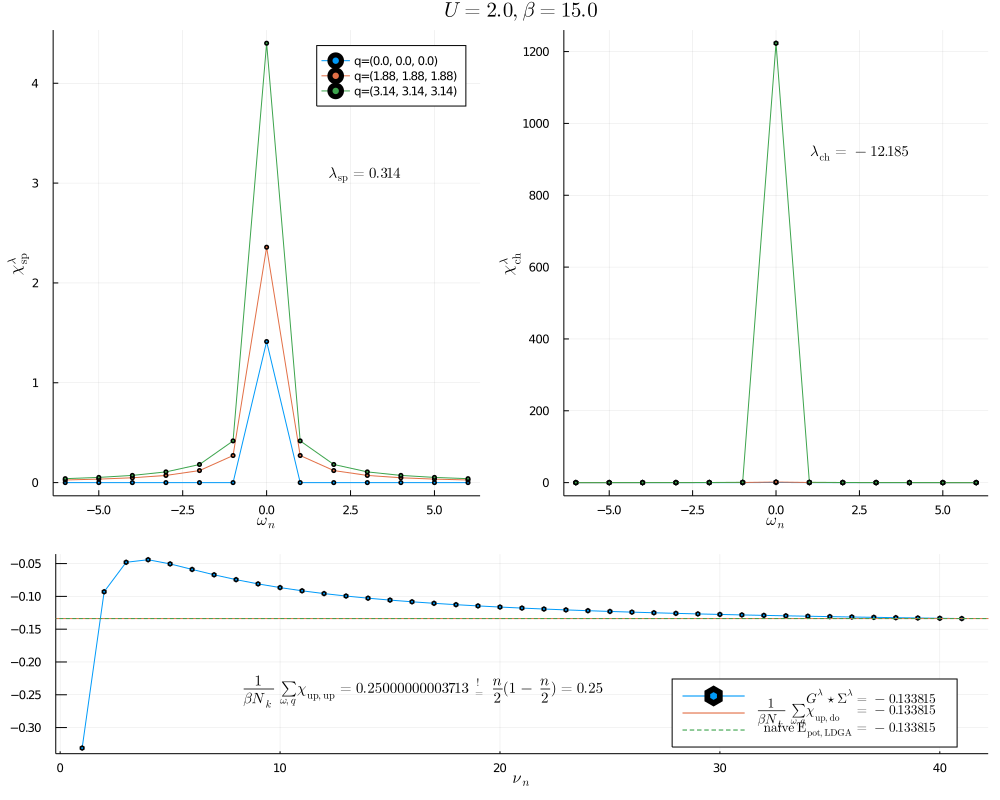

In [66]:
using LaTeXStrings
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_nc.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_nc.zero[2])
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  
lhs_c1 = 2 * mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_nc.zero[1], res_nc.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=false);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);


l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β)", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_nc.zero[1],digits=3))", :right, 10))

    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_nc.zero[2],digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=9)
plot!([-rhs_c2], seriestype = :hline, label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(-rhs_c2, digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA, digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1 / 2,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
#savefig("cond_solution_tc_test_b15U2.pdf")

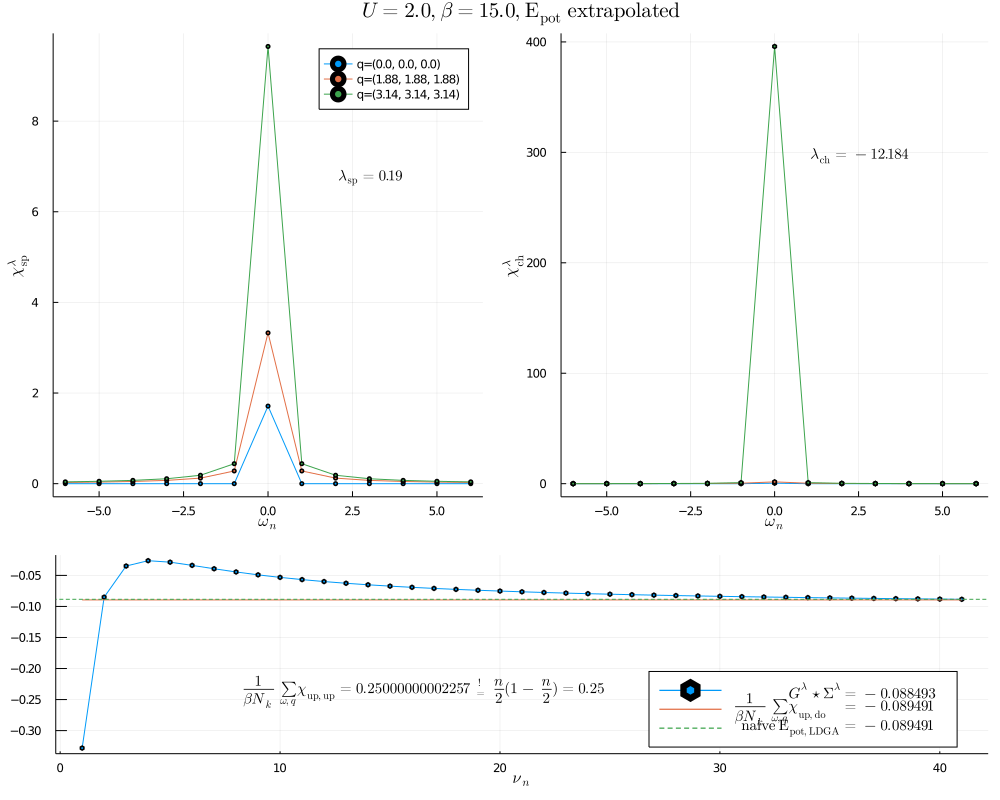

In [69]:
using LaTeXStrings
χsp_λ = LadderDGA.χ_λ(real.(nlQ_sp.χ[usable_ω,:]), res_c.zero[1])
χch_λ = LadderDGA.χ_λ(real.(nlQ_ch.χ[usable_ω,:]), res_c.zero[2])
χupup = LadderDGA.sum_q(χch_λ .+ χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
χupdo = LadderDGA.sum_q(χch_λ .- χsp_λ, LadderDGA.qMultiplicity, dims=2)[:,1]
rhs_c1 = real(LadderDGA.sum_freq(χupup, [1], true, mP.β, weights=Wω)[1])  
rhs_c2 = mP.U * real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω)[1])  
lhs_c1 = 2 * mP.n/2 * (1 - mP.n/2)
Σ_ladder2, lhs_c2, E_pot_DGA = LadderDGA.calc_E_pot_cond(res_c.zero[1], res_c.zero[2], nlQ_sp, nlQ_ch, bubble, 
                     LadderDGA.ϵkGrid, LadderDGA.FUpDo, 
                     LadderDGA.Σ_loc_pos,Σ_ladderLoc,
                     LadderDGA.qIndices, LadderDGA.qMultiplicity, 
                     mP, sP, sP.tail_corrected, E_pot_tail_corr=true);
E_Kin, E_Pot = LadderDGA.calc_E(Σ_ladder2, LadderDGA.ϵqGrid, LadderDGA.qMultiplicity, sP.Nk, mP, sP);

l = @layout [A{0.01h}; 
             [grid(1,2)
              b{0.3h}]]
nhi = 20
xarr = usable_ω .- ceil(Int64, size(bubble,1)/2)
title = plot(title = L"U=%$(mP.U), \beta=%$(mP.β), \mathrm{E}_\mathrm{pot} \mathrm{\;extrapolated}", grid = false, showaxis = false, bottom_margin = -50Plots.px)
p1 = plot(xarr, χsp_λ[:,1], legend = true, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{sp}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:circle, markersize=2)
plot!(xarr, χsp_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:circle, markersize=2)
annotate_y_pos = 0.7*maximum([maximum(χsp_λ[:,1]), maximum(χsp_λ[:,nhi]), maximum(χsp_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{sp} = %$(round(res_c.zero[1],digits=3))", :right, 10))
    
p2 = plot(xarr, χch_λ[:,1], legend = false, xlabel=L"\omega_n", ylabel=L"\chi^\lambda_{\mathrm{ch}}", label="q=$(round.(LadderDGA.qGrid[1],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,nhi], label="q=$(round.(LadderDGA.qGrid[nhi],digits=2))", markershape=:hexagon, markersize=2)
plot!(xarr, χch_λ[:,end], label="q=$(round.(LadderDGA.qGrid[end],digits=2))", markershape=:hexagon, markersize=2)
annotate_y_pos = 0.75*maximum([maximum(χch_λ[:,1]), maximum(χch_λ[:,nhi]), maximum(χch_λ[:,end])])
annotate!(xarr[end-2], annotate_y_pos, text(L"\lambda_\mathrm{ch} = %$(round(res_c.zero[2],digits=3))", :right, 10))


p3 = plot(E_Pot, xlabel=L"\nu_n", label=L"\qquad\qquad\;\;\; G^\lambda \star \Sigma^\lambda = %$(round(E_Pot[end], digits=6))", markershape=:hexagon, markersize=2,legend=:bottomright, legendfontsize=10)
plot!(repeat([rhs_c2], length(E_Pot)), label=L"\frac{1}{\beta N_k} \sum_{\omega,q} \chi_\mathrm{up, do}\quad\, = %$(round(rhs_c2, digits=6))")
#plot!([E_pot_DGA[1]], seriestype = :hline, linestyle=:dash, label=L"\qquad\qquad\mathrm{E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
plot!([E_Pot[end]], seriestype = :hline, linestyle=:dash, label=L"\mathrm{\;\;\;naive\;E}_\mathrm{pot, LDGA} = %$(round(E_pot_DGA[1], digits=6))")
annotate_y_pos = (0.3*(maximum(E_Pot) - minimum(E_Pot)) + minimum(E_Pot))
annotate!(0.2*length(E_Pot), annotate_y_pos, text(L"\frac{1}{\beta N_k}\sum_{\omega,q} \chi_\mathrm{up, up} = %$(round(rhs_c1 / 2,digits=14)) \stackrel{!}{=} \frac{n}{2} (1-\frac{n}{2}) = %$(mP.n/2 *(1 - mP.n/2))", :left, 10))

plot(title, p1, p2, p3, layout = l, size=(1000,800))
#savefig("cond_solution_tc_test_b15U2.pdf")

In [72]:
println(E_Pot[end])
println(Shanks.shanks(E_Pot, csum_inp=true)[1])

-0.08849311176952186
-0.0894908470355597


In [330]:
E_Pot[end]

-0.1338149056686282

In [331]:
include("src/ConvergenceAcc.jl")
Shanks.shanks(E_Pot, csum_inp=true) 

(-0.13517828059904885, 20)

In [414]:
ωmin2 = 1#Int(floor(last(usable_ω .- sP.n_iω)*3/4))
ωmax2 = Int(last(usable_ω) - sP.n_iω) - 1
Wω_1 = LadderDGA.build_weights(ωmin2, ωmax2, [0,1,2,3])
Wω_2 = LadderDGA.build_weights(ωmin2, ωmax2, [0,1,2,3,4])
Wω_3 = LadderDGA.build_weights(ωmin2, ωmax2, [0,1,2,3,4,5])
Wω_4 = LadderDGA.build_weights(ωmin2, ωmax2, [0,2,4,6])
χupdo_naive = mP.U .* (χupdo[13] + 2 * sum(χupdo[14:end])) ./ mP.β
χupdo_shanks = mP.U .* (χupdo[13] + 2 * Shanks.shanks(χupdo[14:end])[1]) ./ mP.β
χupdo_richardson = mP.U .* (χupdo[13] + 2 * Float64(Shanks.richardson(χupdo[14:end])[end-1])) ./ mP.β
χupdo_GFFit_1 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_1)[1]))
χupdo_GFFit_2 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_2)[1]))
χupdo_GFFit_3 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_3)[1]))
χupdo_GFFit_4 = mP.U * (real(LadderDGA.sum_freq(χupdo, [1], true, mP.β, weights=Wω_4)[1]))

println("""Naive = $χupdo_naive
Shanks = $χupdo_shanks
Richardson = $χupdo_richardson
GFFit(1:12,0:3) = $(χupdo_GFFit_1)
GFFit(1:12,0:4) = $(χupdo_GFFit_2)
GFFit(1:12,0:5) = $(χupdo_GFFit_3)
GFFit(1:12,[0,2,4,6]) = $(χupdo_GFFit_4)""")

Naive = -0.13491564533599373
Shanks = -0.13536593874628322
Richardson = -0.1350100865612612
GFFit(1:12,0:3) = -0.13714815359721577
GFFit(1:12,0:4) = -0.13525023028434366
GFFit(1:12,0:5) = -0.1347350940001175
GFFit(1:12,[0,2,4,6]) = -0.13580764633303455
